# Finesse Tutorial: Investigating the effect of an input mode cleaner on laser frequency noise


Alina Soflau, Yashwant Bothra, Enzo Tapia, Andreas Freise, Nikhef, 14.10.2025

This notebook was used in the IMPRS School "Gravity at the Extreme: from Theory to Observation"< October 2025>

### Overview


We study how the Input Mode Cleaner (IMC) affects laser frequency noise in a realistic interferometric gravitational-wave detector model. We begin with a dual-recycled Fabry–Pérot Michelson interferometer (DRFPMI), that is, a Michelson interferometer with Fabry–Pérot arm cavities, a Power Recycling Mirror (PRM), and a Signal Recycling Mirror (SRM). At first, the interferometer has no Input Mode Cleaner (IMC) and no Output Mode Cleaner (OMC). We then add the IMC and re-evaluate the system’s response to laser frequency fluctuations.


### In this notebook you will learn to:


- Apply the transfer function formalism to laser frequency noise;

- Model an Input Mode Cleaner in Finesse 3 and understand its optical layout;

- Compare the strain-equivalent noise spectra due to laser frequency noise, for a real interferometer model with and without an Input Mode Cleaner (IMC).



### 1. Background


Gravitational-wave interferometers such as LIGO and Virgo are extremely sensitive to laser frequency noise. If unfiltered, this noise can mimic a true gravitational-wave signal by changing the phase of the light that reaches the detectors.

When we talk about laser frequency noise, we mean that the laser’s optical frequency is not perfectly constant in time, but oscillates slightly around its nominal (central) value. If the laser normally emits light at frequency $\nu_0$, then a sinusoidal modulation at a frequency $\nu_m$ and with a modulation depth $\Delta \nu$ can be expressed as:

$$ \nu(t)=
\nu_0 + \delta \nu(t)=
\nu_0+  {\Delta \nu}  \cdot \sin (2 \pi f_{\text{m}}t) $$



A change $ \nu(t)= \nu_0+ \delta \nu(t) $
corresponds to a change in phase of the input field:
$$ E_{\mathrm{in}}(t) =
E_0 e^{i(2\pi \nu_0 t + \delta \phi(t))}. $$

Here
$$
\delta \phi(t)= 2 \pi \Delta \nu \int \sin (2 \pi f_{\text{m}}t) dt =
- \dfrac{\Delta \nu}{ f_{\text{m}}} \cos (2 \pi f_{\text{m}}t)

$$  

Because the interferometer output is determined by the interference between the beams returning from its two arms, fluctuations in the laser frequency alter the interference condition, and thus the detected signal.




### 2. Transfer functions computation

For a given laser frequency noise spectrum $\text{N}_f(f)$, the equivalent strain noise seen at the detector can be written as:

$$ S_h(f) =
\left| \frac{H_f(f)}{H_s(f)} \right| N_f(f), $$

where:

- $\text{N}_f(f)$ is the amplitude spectral density (ASD) of the laser frequency noise, with units of $\text{Hz}/{\sqrt{\text{Hz}}}$;

- $\text{H}_f(f)$ is the transfer function from laser frequency modulation to detector output, with units W/$\sqrt{\text{Hz}}$;

- $\text{H}_s(f)$ is the gravitational-wave signal transfer function, with units W/h.

From dimensional analysis we indeed have:

$$\frac{[\text{Hz}/\sqrt{\text{Hz}}] [W/\text{Hz}]}{[W/h]} = \frac{h}{\sqrt{Hz}}$$


This means that, to evaluate the effect of laser frequency noise on the detector output, given a noise spectrum $\text{N}_f$(f), we must compute two independent transfer functions: one describing how the interferometer responds to a laser frequency modulation, and another describing its response to a gravitational-wave strain.



### 3. The Input Mode Cleaner

You may already be familiar with linear optical cavities, such as the Fabry–Pérot (FP) type, which consist of two mirrors. In such cavities, light bounces back and forth along a straight path, and the design is mainly used to amplify optical power. Here, we deal with a triangular cavity, the IMC, formed by three mirrors (denoted MC1, MC2, and MC3) and three optical paths between them (L12, L13, L23). Some key differences between linear and triangular cavities are:


- In a linear cavity, the reflected beam propagates back along the same axis as the incoming beam; in a triangular cavity, the reflected light exits through a different port, so the spatial separation between input and reflected beams makes control easier.

- Linear cavities are more power-efficient, since each round trip involves only two reflections (reduced losses).

- A triangular geometry allows a long optical path to be folded into a smaller physical space. This is essential since otherwise the setup would be too large, and too expensive.


The IMC is placed between the laser and the main interferometer. Its purpose is to act as the first stage of beam cleaning, by:

- filtering out higher-order spatial modes,
- reducing the laser frequency noise, a feature that we explore in detail in this notebook.

More specifically, the IMC acts as a low-pass filter for the laser’s frequency noise: it transmits the slow variations but suppresses the rapid ones, so the output beam has reduced high-frequency noise.



How “rapid” a variation is depends on how long the light remains stored in the cavity. The storage time quantifies how long the optical field remains stored in the cavity before decaying to 1/e of its original value; during that time, each newly arriving wavefront overlaps and interferes with the field already stored.

- When the laser frequency (and therefore the instantaneous phase) varies slowly (low $f_{\text{sig}}$), each new wavefront that enters is almost in phase with the ones that are already stored; the many reflections add coherently and intracavity field builds up.

- When the laser frequency varies rapidly (high $f_{\text{sig}}$), however, the phase of each new wavefront is already significantly different from the phase of the waves already circulating. Then we endup with an intracavity field that has many waves with different frequencies, that can interfere destructively.


We can compute the average number of round trips a photon makes before escaping, as:


$$  N= \dfrac{ \text{ time spent inside}}{\text{time per round trip }}=

\dfrac{ \tau_c}{ L_{\text{tot}}/c}=

\dfrac{ \tau_c \cdot c }{L_{\text{tot}}}

$$


$$ \tau_c =
\dfrac{ 1}{\text{FWHM} \cdot \pi} $$

This storage time corresponds to a frequency called 'frequency pole':

$$ f_p = \dfrac{1}{2 \pi \tau_c} $$

that marks the transition between the two regimes.


### 4. Modeling the IMC in Finesse

A mirror component has only two ports. That means we can only connect one incoming and one outgoing beam, which is perfect for a linear cavity, in which light bounces back and forth between the two mirrors. To model a triangular cavity in Finesse, we use beam splitter components, because they provide multiple ports (p1,p2,p3,p4, oriented clockwise), allowing us to connect the optical paths properly and close the cavity loop.

In [12]:
# install pypi wheel only on google colab
!env | grep -q 'colab' && pip install finesse || echo 'Not on google colab, assuming finesse already installed'

In [13]:
import matplotlib.pyplot as plt
import numpy as np

import finesse
from finesse.analysis.actions import Xaxis
finesse.init_plotting()

# Task 1. Compute the strain sensitivity arising from laser frequency noise

We start with a dual recycled Fabry Perot Michelson that doesn't include yet the IMC.

In [14]:
base = finesse.Model()

base.parse("""
l LI P=125
s s1 LI.p1 PRM.p1 L=0

# Power recycling mirror
m PRM T=0.03 L=37.5u phi=90 #loss is 37.5 x 10^-6
s prc PRM.p2 bs1.p1 L=53

# Central beamsplitter
bs bs1 R=0.5 T=0.5 phi=0 alpha=45

# X-arm
s sx bs1.p3 ITMX.p1 L=4.5
m ITMX T=0.014 L=37.5u phi=89.997
s Lx ITMX.p2 ETMX.p1 L=3995
m ETMX T=0 L=37.5u phi=89.997

# Y-arm
s sy bs1.p2 ITMY.p1 L=4.45
m ITMY T=0.014 L=37.5u phi=3m
s Ly ITMY.p2 ETMY.p1 L=3995
m ETMY T=0 L=37.5u phi=3m

# Signal recycling mirror
s src bs1.p4 SRM.p1 L=50.525
m SRM T=0.2 L=37.5u phi=-90

# These commands give the mirrors a mass
# by default they are infinitely heavy
free_mass ITMX_sus ITMX.mech mass=40
free_mass ETMX_sus ETMX.mech mass=40
free_mass ITMY_sus ITMY.mech mass=40
free_mass ETMY_sus ETMY.mech mass=40

""")

Goals: compute the two transfer functions needed to express the effect of laser frequency noise in strain-equivalent units: (i) GW signal transfer function, $\text{H}_s(f)$, and (ii)  the laser frequency noise transfer function, $\text{H}_{\text{f, no IMC}}(f)$.



Questions:

1) Where in the interferometer do we inject the laser frequency modulation?
2) What are the units of measure of $\text{H}_{\text{s, no IMC}}(f)$ and $\text{H}_{\text{f, no IMC}}(f)$?
3) What does it physically mean to “modulate the laser frequency”?

In [15]:
# Frequency range for transfer function computation
fstart = 5
fstop = 1e5
Npoints = 400


# ------------------------------------------------------------
# 1. Compute the GW signal transfer function Hs(f)
# A GW makes the distance between the mirrors to oscillate. While one arm is stretched, the other is squeezed
# We pretend a gravitational wave is passing through here, and modulate the space length
# Ly.h -> apply a modulation to the Y arm space; Lx.h -> apply a modulation to the X arm space
# phases are 0° in Y and 180° in X, to create the differential effect:one arm will become short, the other long.
# If I have zero phase, length(t)= length+ A* cos(2pi*f*t)
# If I have 180° phase, length(t)= length-A*cos(2pi*f*t), so 180° is a minus sign.
# ------------------------------------------------------------

# Make another deepcopy of the base model
base1 = base.deepcopy()


#  - Start a signal simulation
#  - Inject a GW-like modulation (modulate both arms with 180° phase shift)
#  - Measure the output signal at SRM.p2.o
base1.parse("""
fsig(1)
sgen sig1 Ly.h 1 0
sgen sig2 Lx.h 1 180
pd1 TF SRM.p2.o f=fsig.f
""")

#  Run the simulation and extract results
out1 = base1.run(Xaxis('fsig.f', 'log', fstart, fstop, Npoints))
# We store the frequency and magnitude of the transfer function [W/h]
# (In general we need to store the magnitude and phase of the transfer
# functions but we only need the magnitude for these examples.)
f_1, Hs_noIMC = out1.x1, np.abs(out1['TF'])



# ------------------------------------------------------------
# 2. Compute the laser frequency noise transfer function Hf(f)
# ------------------------------------------------------------

# Make a deepcopy of the base interferometer model
base2 = base.deepcopy()

#  - Start a signal simulation
#  - Inject a laser frequency modulation with initial amplitude = 1 (normalized), initial phase = 0°
#  - Measure the output signal at the output port SRM.p2.o
base2.parse("""
fsig(1)
sgen sig1 LI.frq 1 0
pd1 TF SRM.p2.o f=fsig.f
""")

# Run the simulation and store the transfer function data
out2 = base2.run(Xaxis('fsig.f', 'log', fstart, fstop, Npoints)
)

# Extract the frequency axis and the magnitude of Hf(f)
f_2, Hf_noIMC = out2.x1, np.abs(out2['TF'])

In this simplified example, we use an artificial model of the laser frequency noise (ultra-stable but free-running laser):

In [16]:
def frequency_noise_ASD(f):
    f = np.array(f)
    return 1e4/abs(np.random.normal(f, 0, size=f.size))

N_f = frequency_noise_ASD(f_1)

Goal: Below we aim to plot the strain-equivalent noise spectrum, $S_{\text{h, no IMC}}(f)$, due to laser frequency noise.

Complete the code below by inserting the correct quantities and ensuring the units are consistent.

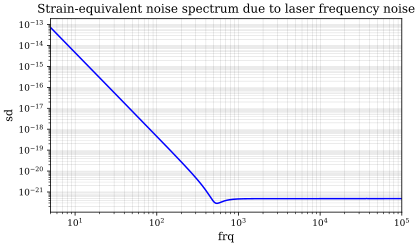

In [17]:
Sh_noIMC = Hf_noIMC * N_f / Hs_noIMC
plt.figure()
plt.loglog(f_1,Sh_noIMC)
plt.xlabel('frq')
plt.ylabel('sd')
plt.title("Strain-equivalent noise spectrum due to laser frequency noise")
plt.tight_layout()
plt.show()

# Task 2: build an Input Mode Cleaner

Goal: construct a triangular cavity in Finesse, with LIGO parameters from  https://finesse.docs.ligo.org/finesse-ligo/parameter_files/llo.html.

Questions:

1) What does a triangular optical cavity look like? Sketch it by hand on paper.

2) How do you connect the mirror ports so that the beam path forms a closed triangular path?

3) What do you think is the main difference between a linear and a triangular cavity?

Cavity pole: 8965.692739715076 [Hz]


/tmp/ipython-input-2866177049.py:34: UserWarning: Graphviz plot requested, but graphviz is not available.Reverting to networkx.
  IMC_losses.plot_graph()
/tmp/ipython-input-2866177049.py:34: UserWarning: Requested layout neato not available in networkx, reverting to spring layout.
  IMC_losses.plot_graph()
/usr/local/lib/python3.12/dist-packages/networkx/drawing/nx_pylab.py:1296: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


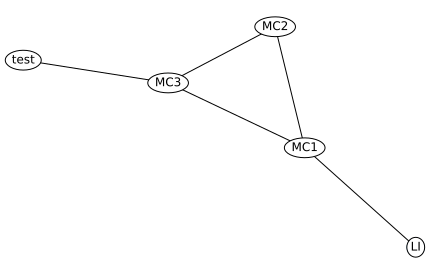

<Figure size 576x355.968 with 0 Axes>

<Figure size 576x355.968 with 0 Axes>

In [18]:
# --- IMC parameters (given) ---
T1, L1 = 6150.0e-6 , 20e-6
T2, L2 = 3.5e-6 , 20e-6
T3, L3 = 6130.0e-6 , 20e-6

# TO DO: compute mirror reflectivities from T and L

R1 = 1 - T1 - L1
R2 = 1 - T2 - L2
R3 = 1 - T3 - L3

IMC_losses = finesse.Model()
IMC_losses.parse(f"""
l LI P=125

# -------- IMC mirrors --------
bs MC1  R={R1}   T={T1}    L={L1} Rc=101609
bs MC2  R={R2}   T={T2}    L={L2} Rc=27.178
bs MC3  R={R3}   T={T3}    L={L3} Rc=171747

# --- Connect spaces to form a triangle ---
s L_MC1   LI.p1     MC1.p1      L=0
s MC1_MC3 MC1.p3   MC3.p1     L=0.465      # fill ports
s MC3_MC2 MC3.p2   MC2.p1     L=16.24057   # fill ports
s MC2_MC1 MC2.p2   MC1.p4     L=16.24057   # fill ports
cav IMC MC2.p2.o
nothing test
s MC3_test MC3.p3 test.p1
""")


print(f'Cavity pole: {IMC_losses.IMC.pole} [Hz]')

IMC_losses.plot_graph()

# Task 3. Investigate the triangular cavity

We take a closer look at the Input Mode Cleaner (IMC) on its own, before adding it to the full interferometer.

Goal: understand how the transmitted, circulating, and reflected powers behave when the IMC is on and off resonance, and how optical losses affect them.


### Task 3.1. Compute reflected, transmitted and circulating powers

Questions:

1) Where should you place photodetectors to measure: reflected, transmitted and circulating power?
2) How can you vary the resonance condition of the cavity?

(Hint: scanning the phase of one mirror, e.g. MC3.phi, is equivalent to sweeping the laser frequency.)

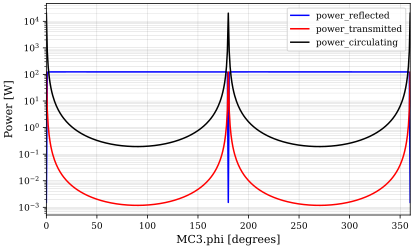

{finesse.detectors.powerdetector.PowerDetector: <Figure size 576x355.968 with 1 Axes>,
 'power_reflected': <Figure size 576x355.968 with 1 Axes>,
 'power_transmitted': <Figure size 576x355.968 with 1 Axes>,
 'power_circulating': <Figure size 576x355.968 with 1 Axes>}

In [20]:
IMC_losses1 = IMC_losses.deepcopy()
IMC_losses1.parse("""
# TODO: place three photodiodes to measure:
#  - Reflected power from the cavity
#  - Transmitted power through the cavity
#  - Circulating power inside the cavity
# (Hint: think about MC1 and MC3 ports)
pd power_reflected   MC1.p2.o
pd power_transmitted MC3.p3.o
pd power_circulating MC1.p3.o


""")

sol_IMC_1 = IMC_losses1.run(Xaxis('MC3.phi','lin',0,360,400))
sol_IMC_1.plot(logy= True)

### Task 3.2. Compare the transmitted power by the IMC with the laser power

Now that you can compute the transmitted power through the Input Mode Cleaner, let’s compare it to the input laser power.

Questions:

1) Do you expect the power transmitted by the IMC to be exactly equal to the input laser power? If not, where do you think the missing power goes?

2) How would the transmitted power change if the mirrors had no optical losses, or if one mirror were perfectly reflective?

In [21]:
IMC_comparison = IMC_losses.deepcopy()
IMC_comparison.parse("""
# TODO: add a photodiode to measure the transmitted power at the IMC output
pd power_transmitted MC3.p3.o
""")

# Compare the TRANSMITTED power to the original laser power in this model WITH losses.

sol_comparison = IMC_comparison.run()

power_incident = float(IMC_losses.LI.P)
print(f"Incident laser power (for model base IMC): {power_incident:.3f} W")
print(f"Power transmitted by IMC [W] (for model base IMC): {sol_comparison['power_transmitted']:.3f}")

Incident laser power (for model base IMC): 125.000 W
Power transmitted by IMC [W] (for model base IMC): 123.720


# Task 4. Add the IMC to the full interferometric model

Now it’s time to integrate the IMC into the full interferometer model.

Questions:

1) Where do you think the IMC should be placed in the interferometer, and why?

2) Like any cavity, the IMC acts as a filter: it stores light for a short time and only lets certain “well-behaved” light through. What do you expect the IMC to do to the laser frequency noise?


In [ ]:
T1, L1 = 6150.0e-6 , 20e-6
T2, L2 = 3.5e-6 , 20e-6
T3, L3 = 6130.0e-6 , 20e-6

R1 = 1 - T1 - L1
R2 = 1 - T2 - L2
R3 = 1 - T3 - L3


complete_IMC = finesse.Model()

complete_IMC.parse(f"""
l LI P=125

# -------- IMC mirrors --------
# from https://finesse.docs.ligo.org/finesse-ligo/parameter_files/llo.html
# L = 20 ppm on all three; R = 1 - T - L
# Light transmitted through MC1 (from p1 to p3))enters MC2 (through p1, then reflected through p2), then goes into MC3 (enters in p1, reflected in p2).
# Finally returns from MC3.p2 into MC1.p4, which reflects into MC1.p3, closing the triangular cavity.
bs MC1  R={R1}   T={T1}    L={L1} Rc= # your code here
bs MC2  R={R2}   T={T2}    L={L2} Rc= # your code here
bs MC3  R={R3}   T={T3}    L={L3} Rc= # your code here


s L_MC1 LI.p1 MC1.p1 L=0
s MC1_MC3 MC1.p__   MC3.p__     L=   # fill ports and lengths
s MC3_MC2 MC3.p__   MC2.p__     L=   # fill ports and lengths
s MC2_MC1 MC2.p__   MC1.p__     L=   # fill ports and lengths
s IMC_to_PRM # your code here (missing ports connection) L=4


# Power recycling mirror
m PRM T=0.03 L=37.5u phi=90 #loss is 37.5 x 10^-6
s prc PRM.p2 bs1.p1 L=53

# Central beamsplitter
bs bs1 R=0.5 T=0.5 phi=0 alpha=45

# X-arm
s sx bs1.p3 ITMX.p1 L=4.5
m ITMX T=0.014 L=37.5u phi=89.997
s Lx ITMX.p2 ETMX.p1 L=3995
m ETMX T=0 L=37.5u phi=89.997

# Y-arm
s sy bs1.p2 ITMY.p1 L=4.45
m ITMY T=0.014 L=37.5u phi=3m
s Ly ITMY.p2 ETMY.p1 L=3995
m ETMY T=0 L=37.5u phi=3m

# Signal recycling mirror
s src bs1.p4 SRM.p1 L=50.525
m SRM T=0.2 L=37.5u phi=-90

# These commands give the mirrors a mass
# by default they are infinitely heavy
free_mass ITMX_sus ITMX.mech mass=40
free_mass ETMX_sus ETMX.mech mass=40
free_mass ITMY_sus ITMY.mech mass=40
free_mass ETMY_sus ETMY.mech mass=40
""")

# Task 5. Compute the laser frequency noise for the full interferometric model with IMC (and compare to without IMC)

Goal:

  Plot the total system transfer functions  $\text{H}_{\text{f, IMC}}$  and  $\text{H}_{\text{f, no IMC}}$  (with and without the IMC) and highlight the pole frequency (8965 Hz).


Questions:


1) At what frequency do you expect $H_{\text{f, IMC}}$ to deviate visibly from $H_{\text{f, no IMC}}$?

2) Why does the pole frequency appear after the slope of the transfer function has already started to decrease?


We start by making two deepcopies of the complete model, with IMC, in order to compute the two transfer functions we need (similar procedure to the model without IMC).

In [ ]:
transfer_function_1 = complete_IMC.deepcopy()
transfer_function_1.parse(f"""
# your code here
""")
out_1 = transfer_function_1.run(Xaxis('fsig.f', 'log', fstart, fstop, Npoints))

f_1, Hs_IMC = out_1.x1, np.abs(out_1['TF'])


transfer_function_2 = complete_IMC.deepcopy()
transfer_function_2.parse(f"""
# your code here
""")

out_2 = transfer_function_2.run(Xaxis('fsig.f', 'log', fstart, fstop, Npoints))
f_2, Hf_IMC = out_2.x1, np.abs(out_2['TF'])

In [ ]:
# Complete the code below by inserting the correct quantities.

plt.figure()
plt.loglog() # your code here
plt.loglog() # your code here
# The vertical dashed line marks the IMC pole frequency (8.965 kHz),
# which was already computed from the cavity parameters.
plt.axvline(x=8965, color='k', linestyle='--', linewidth=1, label='Frequency pole = 8.965 kHz')
plt.xlabel() # your code here
plt.ylabel() # your code here
plt.legend()
plt.title('Laser frequency noise transfer function')
plt.tight_layout()
plt.show()

In a separate plot, take their ratio,

$$R(f)=

\dfrac{\text{H}_{\text{f, IMC}} }{\text{H}_{\text{f, no IMC}}} $$

and compare it to the magnitude of a one-pole low-pass transfer function,

\begin{equation}
T_{\mathrm{LP}}(f) = \frac{1}{1 + i (f/f_p)},
\qquad
|T_{\mathrm{LP}}(f)| = \frac{1}{\sqrt{1+(f/f_p)^2}},
\end{equation}

 to see how closely the real IMC behaves like a single-pole filter.

Remember that $f_p$, the cavity pole frequency, was already computed to be 8.965 kHz.

In [ ]:
f_p = 8965
FR_theory = # your code here

plt.figure()
plt.loglog() # your code here (TF ratio)
plt.loglog() # your code here (IMC filter response)
plt.axvline(x=8965, color='k', linestyle='--', linewidth=1, label='Frequency pole = 8.965 kHz')
plt.legend()
plt.show()

Goal: plot below $\text{H}_{\text{s, IMC}}$ and $\text{H}_{\text{s,no IMC}}$.


Question:

- Why do the gravitational-wave signal transfer functions $H_s(f)$ with and without the IMC appear nearly identical?

In [ ]:
plt.figure()
plt.loglog() # your code here (without IMC)
plt.loglog() # your code here (with IMC)
plt.xlabel() # your code here (units of measure)
plt.ylabel() # your code here (units of measure)
plt.legend(); plt.tight_layout(); plt.show()

Goal:
Below, compute and compare the total strain-equivalent noise spectrum, $S_{\text{h}}(f)$ arising from laser frequency noise, for the two cases:
- Without the IMC, $S_{\text{h, no IMC}}(f)$ and
- With the IMC included, $S_{\text{h, IMC}}(f)$.


In [ ]:
Sh_IMC = # your code here

plt.figure()
plt.loglog() # your code here (without IMC)
plt.loglog() # your code here (with IMC)
plt.xlabel() # your code here (units of measure)
plt.ylabel() # your code here (units of measure)
plt.legend(); plt.tight_layout(); plt.show()